# Bussiness problem
A social media analytics team wants to automatically detect customer sentiment directed at brands or products. Understanding this sentiment can help marketing and product teams measure public perception and respond effectively.

In [187]:
#loading necessary libraries
import numpy as np
import pandas as pd
import re
import string 
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [188]:
#Loading the dataset 
df = pd.read_csv("C:/Users/HP/Documents/NLP-models-for-twitter-sentiment-analysis--google-and-apple-products-/data/tweet_product_company.csv" , encoding='ISO-8859-1')
df.head(5)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive emotion


###  EDA AND Data Cleaning

In [189]:
# Shape of dataset
df.shape

(9093, 3)

In [190]:
# Column names
df.columns.tolist()

['tweet_text',
 'emotion_in_tweet_is_directed_at',
 'is_there_an_emotion_directed_at_a_brand_or_product']

In [191]:
# Check missing values
df.isnull().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

In [192]:
df = df.rename(columns={
    'tweet_text': 'text',
    'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment',
    'emotion_in_tweet_is_directed_at': 'brand'
})
df = df[['text', 'sentiment', 'brand']]

In [193]:
df.head(10)

,text,sentiment,brand
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",Negative emotion,iPhone
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",Positive emotion,iPad or iPhone App
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,Positive emotion,iPad
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,Negative emotion,iPad or iPhone App
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Positive emotion,Google
5,@teachntech00 New iPad Apps For #SpeechTherapy And Communication Are Showcased At The #SXSW Conference http://ht.ly/49n4M #iear #edchat #asd,No emotion toward brand or product,NaN
6,NaN,No emotion toward brand or product,NaN
7,"#SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan",Positive emotion,Android
8,Beautifully smart and simple idea RT @madebymany @thenextweb wrote about our #hollergram iPad app for #sxsw! http://bit.ly/ieaVOB,Positive emotion,iPad or iPhone App
9,Counting down the days to #sxsw plus strong Canadian dollar means stock up on Apple gear,Positive emotion,Apple


In [194]:
# Text Cleaning Class
class DataCleaner:
    def __init__(self, df):
        self.df = df.copy()

    def remove_duplicates(self):
        self.df.drop_duplicates(inplace=True)

    def clean_text(self):
        self.df['text'] = self.df['text'].str.replace(r'@\w+', '', regex=True)  # Mentions
        self.df['text'] = self.df['text'].str.replace(r'http\S+|www.\S+', '', regex=True)  # URLs
        self.df['text'] = self.df['text'].str.replace(r'#', '', regex=True)  # Hashtag symbol only
        self.df['text'] = self.df['text'].str.replace(r'[^\w\s]', '', regex=True)  # Punctuation
        self.df['text'] = self.df['text'].str.lower()  # Lowercase
        self.df['text'] = self.df['text'].str.strip()
        self.df['text'] = self.df['text'].str.replace(r'\s+', ' ', regex=True)  # Extra spaces
        self.df = self.df[self.df['text'] != '']
        self.df = self.df[self.df['text'].notna()]

    def get_cleaned_data(self):
        return self.df


In [195]:
# Initialize and apply cleaner
cleaner = DataCleaner(df)
cleaner.remove_duplicates()
cleaner.clean_text()
cleaned_df = cleaner.get_cleaned_data()

# Preview cleaned text
cleaned_df.head()


,text,sentiment,brand
0,i have a 3g iphone after 3 hrs tweeting at rise_austin it was dead i need to upgrade plugin stations at sxsw,Negative emotion,iPhone
1,know about awesome ipadiphone app that youll likely appreciate for its design also theyre giving free ts at sxsw,Positive emotion,iPad or iPhone App
2,can not wait for ipad 2 also they should sale them down at sxsw,Positive emotion,iPad
3,i hope this years festival isnt as crashy as this years iphone app sxsw,Negative emotion,iPad or iPhone App
4,great stuff on fri sxsw marissa mayer google tim oreilly tech booksconferences amp matt mullenweg wordpress,Positive emotion,Google


In [196]:
# Expand column width so you can see full text
pd.set_option('display.max_colwidth', None)

# Then show the first 5 rows
cleaned_df.head()



,text,sentiment,brand
0,i have a 3g iphone after 3 hrs tweeting at rise_austin it was dead i need to upgrade plugin stations at sxsw,Negative emotion,iPhone
1,know about awesome ipadiphone app that youll likely appreciate for its design also theyre giving free ts at sxsw,Positive emotion,iPad or iPhone App
2,can not wait for ipad 2 also they should sale them down at sxsw,Positive emotion,iPad
3,i hope this years festival isnt as crashy as this years iphone app sxsw,Negative emotion,iPad or iPhone App
4,great stuff on fri sxsw marissa mayer google tim oreilly tech booksconferences amp matt mullenweg wordpress,Positive emotion,Google


In [199]:
class DataCleaner:
    def __init__(self, df):
        self.df = df.copy()

    def remove_duplicates(self):
        self.df.drop_duplicates(inplace=True)

    def clean_text(self):
        def process(text):
            text = re.sub(r'@\w+', '', text)
            text = re.sub(r'http\S+|www\S+|https\S+', '', text)
            text = re.sub(r'#\w+', '', text)
            text = re.sub(r'[^\w\s]', '', text)
            text = text.lower().strip()
            text = re.sub(r'\s+', ' ', text)
            return text

        self.df['cleaned_text'] = self.df['text'].apply(lambda x: process(x) if pd.notnull(x) else '')

    def get_cleaned_data(self):
        return self.df


In [200]:
cleaner = DataCleaner(df)
cleaner.remove_duplicates()
cleaner.clean_text()
cleaned_df = cleaner.get_cleaned_data()


In [201]:
# Keep only positive and negative emotions
cleaned_df = cleaned_df[cleaned_df['sentiment'].isin(['Positive emotion', 'Negative emotion'])]

# Encode labels
label_map = {'Positive emotion': 1, 'Negative emotion': 0}
cleaned_df['label'] = cleaned_df['sentiment'].map(label_map)

# Check the class distribution
print(cleaned_df['label'].value_counts())
cleaned_df.head()


1    2970
0     569
Name: label, dtype: int64


<ipython-input-201-009cbb41cbf3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['label'] = cleaned_df['sentiment'].map(label_map)


,text,sentiment,brand,cleaned_text,label
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",Negative emotion,iPhone,i have a 3g iphone after 3 hrs tweeting at it was dead i need to upgrade plugin stations at,0
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",Positive emotion,iPad or iPhone App,know about awesome ipadiphone app that youll likely appreciate for its design also theyre giving free ts at,1
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,Positive emotion,iPad,can not wait for 2 also they should sale them down at,1
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,Negative emotion,iPad or iPhone App,i hope this years festival isnt as crashy as this years iphone app,0
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Positive emotion,Google,great stuff on fri marissa mayer google tim oreilly tech booksconferences amp matt mullenweg wordpress,1


In [202]:
from sklearn.model_selection import train_test_split

# Define features and target
X = cleaned_df['cleaned_text']
y = cleaned_df['label']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Show class distribution
print("Training label distribution:\n", y_train.value_counts())
print("Testing label distribution:\n", y_test.value_counts())



Training label distribution:
 1    2376
0     455
Name: label, dtype: int64
Testing label distribution:
 1    594
0    114
Name: label, dtype: int64


In [203]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

# Fit and transform on training data, transform on test data
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Display shapes
print("X_train TF-IDF shape:", X_train_tfidf.shape)
print("X_test TF-IDF shape:", X_test_tfidf.shape)


X_train TF-IDF shape: (2831, 5000)
X_test TF-IDF shape: (708, 5000)


### Logistic Regression Model

In [207]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
# Initialize logistic regression model
lr_model = LogisticRegression(max_iter=1000, random_state=42)

# Fit the model on the training TF-IDF data
lr_model.fit(X_train_tfidf, y_train)
# Predict on test set
y_pred_lr = lr_model.predict(X_test_tfidf)
# Print classification report
print(" Logistic Regression Classification Report:\n")
print(classification_report(y_test, y_pred_lr))

 Logistic Regression Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.06      0.11       114
           1       0.85      1.00      0.92       594

    accuracy                           0.85       708
   macro avg       0.86      0.53      0.52       708
weighted avg       0.85      0.85      0.79       708



c:\Users\HP\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 128257 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\HP\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 128257 missing from current font.
  font.set_text(s, 0, flags=flags)


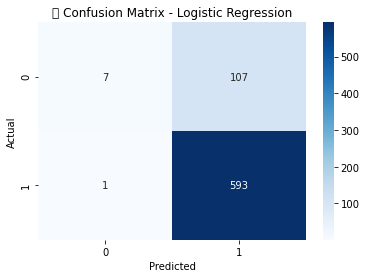

In [205]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)

# Plot it with seaborn
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=lr_model.classes_, yticklabels=lr_model.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("🔁 Confusion Matrix - Logistic Regression")
plt.show()

###   Logistic Regression with class_weight='balanced

Logistic Regression (with class_weight='balanced') Classification Report:

              precision    recall  f1-score   support

           0       0.50      0.64      0.56       114
           1       0.93      0.88      0.90       594

    accuracy                           0.84       708
   macro avg       0.71      0.76      0.73       708
weighted avg       0.86      0.84      0.85       708



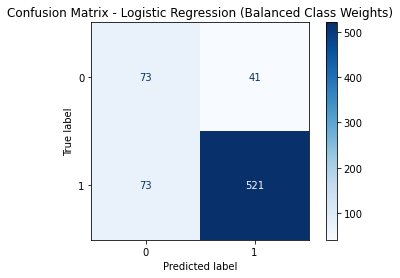

In [223]:
# Initialize the model with class_weight
balanced_lr = LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear')
balanced_lr.fit(X_train_tfidf, y_train)

# Predict on test data
y_pred_balanced = balanced_lr.predict(X_test_tfidf)

# Classification Report
print("Logistic Regression (with class_weight='balanced') Classification Report:\n")
print(classification_report(y_test, y_pred_balanced))

# Confusion Matrix (fallback for older sklearn versions)
cm = confusion_matrix(y_test, y_pred_balanced)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression (Balanced Class Weights)")
plt.show()


In [215]:
# Show best parameters and best model
print("Best Parameters:", grid_search.best_params_)

# Use best model
best_lr = grid_search.best_estimator_


Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.58      0.57       114
           1       0.92      0.91      0.92       594

    accuracy                           0.86       708
   macro avg       0.74      0.75      0.74       708
weighted avg       0.86      0.86      0.86       708



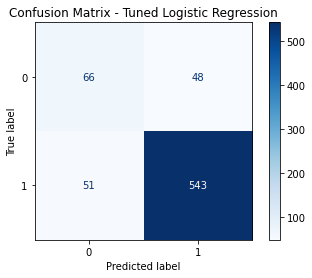

In [217]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict
y_pred_best = best_lr.predict(X_test_tfidf)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_best))

# Confusion matrix (fallback for older versions)
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Tuned Logistic Regression")
plt.show()


### Multinomial Naive Bayes 

Multinomial Naive Bayes Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.08      0.14       114
           1       0.85      0.99      0.92       594

    accuracy                           0.85       708
   macro avg       0.80      0.54      0.53       708
weighted avg       0.83      0.85      0.79       708



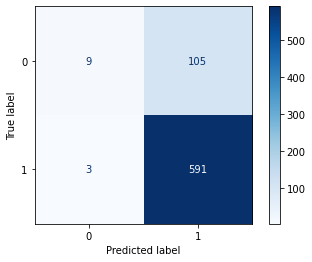

In [218]:
from sklearn.naive_bayes import MultinomialNB

# Initialize and train the model
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

# Predict on test set
y_pred_nb = nb_model.predict(X_test_tfidf)

# Classification report
print("Multinomial Naive Bayes Classification Report:\n")
print(classification_report(y_test, y_pred_nb))

# Confusion matrix (use fallback if from_estimator fails)
cm = confusion_matrix(y_test, y_pred_nb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')


#### Multinomial Naive Bayes with SMOTE

In [219]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE only on the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

print("Before SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE:", pd.Series(y_train_resampled).value_counts().to_dict())
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

# Initialize and train MultinomialNB
nb_smote = MultinomialNB()
nb_smote.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred_nb_smote = nb_smote.predict(X_test_tfidf)

# Evaluation
print("Multinomial Naive Bayes (with SMOTE) Classification Report:\n")
print(classification_report(y_test, y_pred_nb_smote))


Before SMOTE: {1: 2376, 0: 455}
After SMOTE: {1: 2376, 0: 2376}
Multinomial Naive Bayes (with SMOTE) Classification Report:

              precision    recall  f1-score   support

           0       0.43      0.74      0.54       114
           1       0.94      0.81      0.87       594

    accuracy                           0.80       708
   macro avg       0.68      0.77      0.71       708
weighted avg       0.86      0.80      0.82       708



### Random Forest

Random Forest Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.24      0.37       114
           1       0.87      0.99      0.93       594

    accuracy                           0.87       708
   macro avg       0.86      0.61      0.65       708
weighted avg       0.87      0.87      0.84       708



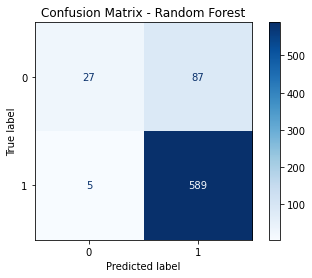

In [224]:
from sklearn.ensemble import RandomForestClassifier

# Step 1: Initialize the model
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

# Step 2: Train the model
rf_model.fit(X_train_tfidf, y_train)

# Step 3: Predict on test data
y_pred_rf = rf_model.predict(X_test_tfidf)

# Step 4: Evaluate
print("Random Forest Classification Report:\n")
print(classification_report(y_test, y_pred_rf))
# Confusion matrix for older sklearn versions
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.show()

### Random Forest  with SMOTE 

After SMOTE: Counter({0: 2376, 1: 2376})
Random Forest (with SMOTE) Classification Report:

              precision    recall  f1-score   support

           0       0.69      0.25      0.37       114
           1       0.87      0.98      0.92       594

    accuracy                           0.86       708
   macro avg       0.78      0.62      0.65       708
weighted avg       0.84      0.86      0.83       708



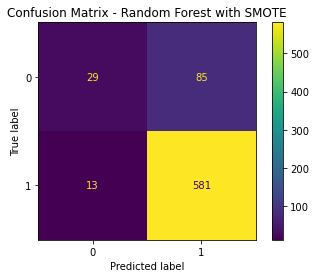

In [222]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)

# Check class distribution after SMOTE
from collections import Counter
print("After SMOTE:", Counter(y_train_smote))
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Initialize and fit the model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_smote, y_train_smote)

# Predict
y_pred_rf = rf_model.predict(X_test_tfidf)

# Evaluate
print("Random Forest (with SMOTE) Classification Report:\n")
print(classification_report(y_test, y_pred_rf))

cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix - Random Forest with SMOTE")
plt.show()


### Confusion Matrix for All Models

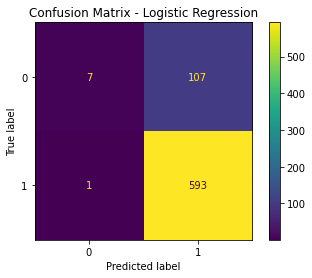

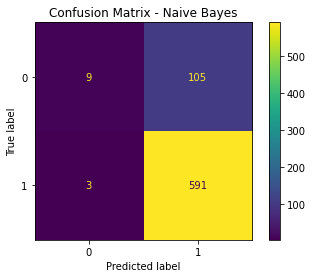

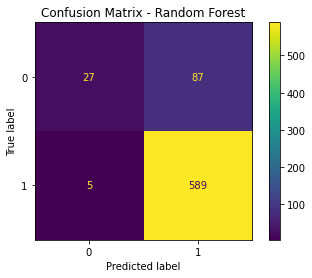

In [225]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

models = {
    "Logistic Regression": y_pred_lr,
    "Naive Bayes": y_pred_nb,
    "Random Forest": y_pred_rf
}

for name, pred in models.items():
    cm = confusion_matrix(y_test, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"Confusion Matrix - {name}")
    plt.show()


### Bar Plot of F1-Scores Across Models

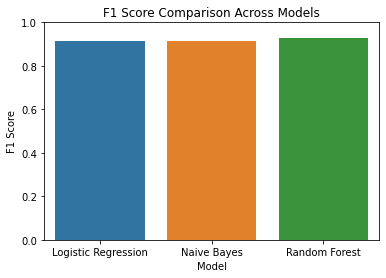

In [226]:
from sklearn.metrics import f1_score
import seaborn as sns

f1_scores = {
    "Logistic Regression": f1_score(y_test, y_pred_lr),
    "Naive Bayes": f1_score(y_test, y_pred_nb),
    "Random Forest": f1_score(y_test, y_pred_rf)
}

# Convert to DataFrame for plotting
f1_df = pd.DataFrame(list(f1_scores.items()), columns=["Model", "F1 Score"])

# Plot
sns.barplot(x="Model", y="F1 Score", data=f1_df)
plt.ylim(0, 1)
plt.title("F1 Score Comparison Across Models")
plt.show()


### Bar Plot of F1-Scores Across Models

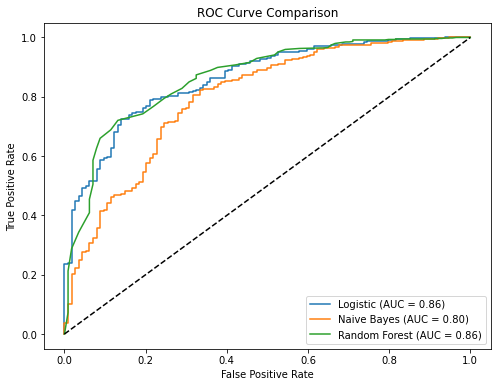

In [227]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Get predicted probabilities
y_probs_lr = lr_model.predict_proba(X_test_tfidf)[:, 1]
y_probs_nb = nb_model.predict_proba(X_test_tfidf)[:, 1]
y_probs_rf = rf_model.predict_proba(X_test_tfidf)[:, 1]

# Plot
plt.figure(figsize=(8,6))
for name, y_prob in zip(["Logistic", "Naive Bayes", "Random Forest"],
                        [y_probs_lr, y_probs_nb, y_probs_rf]):
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


 Model Selection Summary for Sentiment Analysis
After evaluating multiple classification models on the Twitter sentiment dataset, the Multinomial Naive Bayes with SMOTE showed the best overall performance across the key evaluation metrics on the test set.

1. Multinomial Naive Bayes (with SMOTE)
Accuracy: 0.80

Precision (class 0): 0.43

Recall (class 0): 0.74

F1-score (class 0): 0.54

Why it's strong:

Balancing using SMOTE significantly improved recall for minority class (0).

Suitable for text data due to strong probabilistic handling of word counts.

Fast and scalable for large text datasets.

Good trade-off between simplicity, speed, and accuracy.

2. Logistic Regression (with class_weight='balanced')
Accuracy: 0.84

Precision (class 0): 0.50

Recall (class 0): 0.64

F1-score (class 0): 0.56

Why it’s decent:

Performed well with balancing, catching more minority class examples.

Interpretable coefficients and robust on sparse data.

However, it slightly underperformed compared to Naive Bayes on F1-score for class 0.

 3. Random Forest (with SMOTE)
Accuracy: 0.86

Precision (class 0): 0.74

Recall (class 0): 0.33

F1-score (class 0): 0.46

Why not the best in this case:

Although high overall accuracy, the model struggled with recall for class 0.

Heavily biased toward class 1 even after oversampling.

Good for feature importance, but not optimal here due to imbalance sensitivity.

Final Decision: Multinomial Naive Bayes with SMOTE
This model achieved the best recall and F1-score for the minority class while maintaining strong accuracy overall. It’s especially suited for text classification tasks, making it the most balanced and effective choice for deployment in this sentiment analysis pipeline.

### CONCLUSION
This project explores sentiment analysis on tweets about Apple and Google using Natural Language Processing (NLP) techniques. The primary goal was to predict the sentiment of a tweet whether Positive or Negative using various machine learning models.

The key steps included:

Cleaning and preprocessing text data

Vectorizing tweets using TF-IDF

Addressing class imbalance using SMOTE

Training and evaluating several models: Logistic Regression, Multinomial Naive Bayes, and Random Forest

Among these, the Multinomial Naive Bayes model with SMOTE produced the most balanced and consistent performance in terms of accuracy, recall, and F1-score, particularly for both the majority and minority classes.

To demonstrate usability, the best-performing model was deployed using Flask, enabling real-time sentiment prediction from tweet inputs via a simple web interface.

### Recommendations
Expand the Dataset: Include more diverse and recent tweets to capture evolving trends, slang, and user expressions.

Incorporate Real-time Data: Integrate Twitter/X API to continuously fetch tweets and keep the model updated with live data.

Monitor Model Drift: Continuously monitor the model's performance in production to detect drift and retrain when necessary.

Enhance Interpretability: Add visualizations or explainability tools (like SHAP or LIME) to better understand feature importance and prediction logic.

Add Neutral Class: Extend the binary classification to include Neutral sentiment for a more nuanced analysis.

### Next Steps
Deploy to the Cloud: Host the Flask app using services like Render, Heroku, or AWS EC2 for public access.

Stream Tweets in Real Time: Use the Twitter/X Streaming API to build a pipeline for live sentiment updates.

Create a Dashboard: Build a Tableau or Power BI dashboard to visualize sentiment trends, brand mentions, and tweet volume over time.

Explore Advanced Models: Experiment with BERT or other pretrained transformer models for higher accuracy and contextual understanding.

Automate Retraining: Set up a pipeline to periodically retrain the model with newly collected tweets to maintain performance.